# Assignment 1 #

## Read the data ##

In [24]:
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import random
from tqdm import tqdm

In [3]:
# read data into dataframes
instances = {
    "A": pd.read_csv("data/TSPA.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "B": pd.read_csv("data/TSPB.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "C": pd.read_csv("data/TSPC.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "D": pd.read_csv("data/TSPD.csv", sep=';', header=None, names=["x", "y", "cost"]),
}

In [4]:
def calculate_distance_matrix(df: pd.DataFrame) -> NDArray[np.int32]:
    """
    Calculate the distance matrix from the dataframe.
    The dataframe contains 'x' and 'y' columns for the coordinates.
    The distances are Euclidean, rounded to the nearest integer.
    """
    coordinates = df[['x', 'y']].to_numpy()
    dist_matrix = distance_matrix(coordinates, coordinates)
    dist_matrix = np.round(dist_matrix).astype(int)
    return dist_matrix

In [5]:
distances_matrices = {
    "A": calculate_distance_matrix(instances["A"]),
    "B": calculate_distance_matrix(instances["B"]),
    "C": calculate_distance_matrix(instances["C"]),
    "D": calculate_distance_matrix(instances["D"])
}

costs = {
    "A": instances["A"]["cost"].to_numpy(),
    "B": instances["B"]["cost"].to_numpy(),
    "C": instances["C"]["cost"].to_numpy(),
    "D": instances["D"]["cost"].to_numpy()
}

In [6]:
def total_cost(selected_nodes, costs):
    """Calculate the total cost for the selected nodes."""
    return sum(costs[node] for node in selected_nodes)

In [23]:
def visualize_selected_route(
    selected_nodes_indices: ArrayLike, 
    dataframe: pd.DataFrame) -> None:
    """
    Visualize the selected route returned by the algorithm, including the cost of each node represented by a colormap.

    Parameters:
    selected_nodes_indices (list): Indices of the selected nodes in the route.
    dataframe (DataFrame): DataFrame containing 'x', 'y', and 'cost' columns for each node.
    """
    x = dataframe.loc[selected_nodes_indices, 'x']
    y = dataframe.loc[selected_nodes_indices, 'y']
    costs = dataframe.loc[selected_nodes_indices, 'cost']

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(costs), vmax=max(costs))

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(x, y, c=costs, cmap=cmap, norm=norm, s=100)
    plt.colorbar(scatter, label='Node Cost')

    for i, node in enumerate(selected_nodes_indices):
        start_node = selected_nodes_indices[i]
        end_node = selected_nodes_indices[(i + 1) % len(selected_nodes_indices)]
        plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-', lw=1)

    plt.title('Selected Route Visualization with Node Costs', fontsize=18)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.grid(True)
    plt.show()

## Random solution ##

### The algorithm

In [7]:
def generate_random_solution(
    dist_matrix: NDArray[np.int32], 
    costs: np.array
    ) -> tuple[ArrayLike, int]:
    """Generate a random solution to the problem

    Parameters
    ----------
    dist_matrix : NDArray[np.int32]
        distance matrix of the instance
    costs : np.array
        costs of the nodes

    Returns
    -------
    tuple[ArrayLike, int]
        tuple of the selected nodes and the total cost
    """
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2  # round up if odd
    selected_nodes = random.sample(range(num_nodes), num_select)
    random.shuffle(selected_nodes)
    total_distance = sum(
        dist_matrix[selected_nodes[i], selected_nodes[i - 1]] 
        for i in range(num_select)
    )
    # Add the distance between the last and the first node.
    total_distance += dist_matrix[selected_nodes[0], selected_nodes[-1]]
    # Compute the total cost of the selected nodes.
    total_nodes_cost = total_cost(selected_nodes, costs)
    return selected_nodes, total_distance + total_nodes_cost

### Running the method ###

In [12]:
num_solutions = 200
random_solutions = {
    "A": [generate_random_solution(distances_matrices["A"], costs["A"]) for _ in tqdm(range(num_solutions))],
    "B": [generate_random_solution(distances_matrices["B"], costs["B"]) for _ in tqdm(range(num_solutions))],
    "C": [generate_random_solution(distances_matrices["C"], costs["C"]) for _ in tqdm(range(num_solutions))],
    "D": [generate_random_solution(distances_matrices["D"], costs["D"]) for _ in tqdm(range(num_solutions))]
}

objectives_values = {
    "A": [solution[1] for solution in random_solutions["A"]],
    "B": [solution[1] for solution in random_solutions["B"]],
    "C": [solution[1] for solution in random_solutions["C"]],
    "D": [solution[1] for solution in random_solutions["D"]]
}

selected_nodes = {
    "A": [solution[0] for solution in random_solutions["A"]],
    "B": [solution[0] for solution in random_solutions["B"]],
    "C": [solution[0] for solution in random_solutions["C"]],
    "D": [solution[0] for solution in random_solutions["D"]]
}

100%|██████████| 200/200 [00:00<00:00, 4081.61it/s]


In [14]:
for instance in objectives_values:
    print(f"Instance {instance} - min: {min(objectives_values[instance])}, max: {max(objectives_values[instance])}, mean: {np.mean(objectives_values[instance])}")

Instance A - min: 242187, max: 294911, mean: 266794.43
Instance B - min: 241967, max: 297371, mean: 269301.865
Instance C - min: 194292, max: 239091, mean: 217428.155
Instance D - min: 197026, max: 246621, mean: 220104.42


#### Instance A - best solution ###

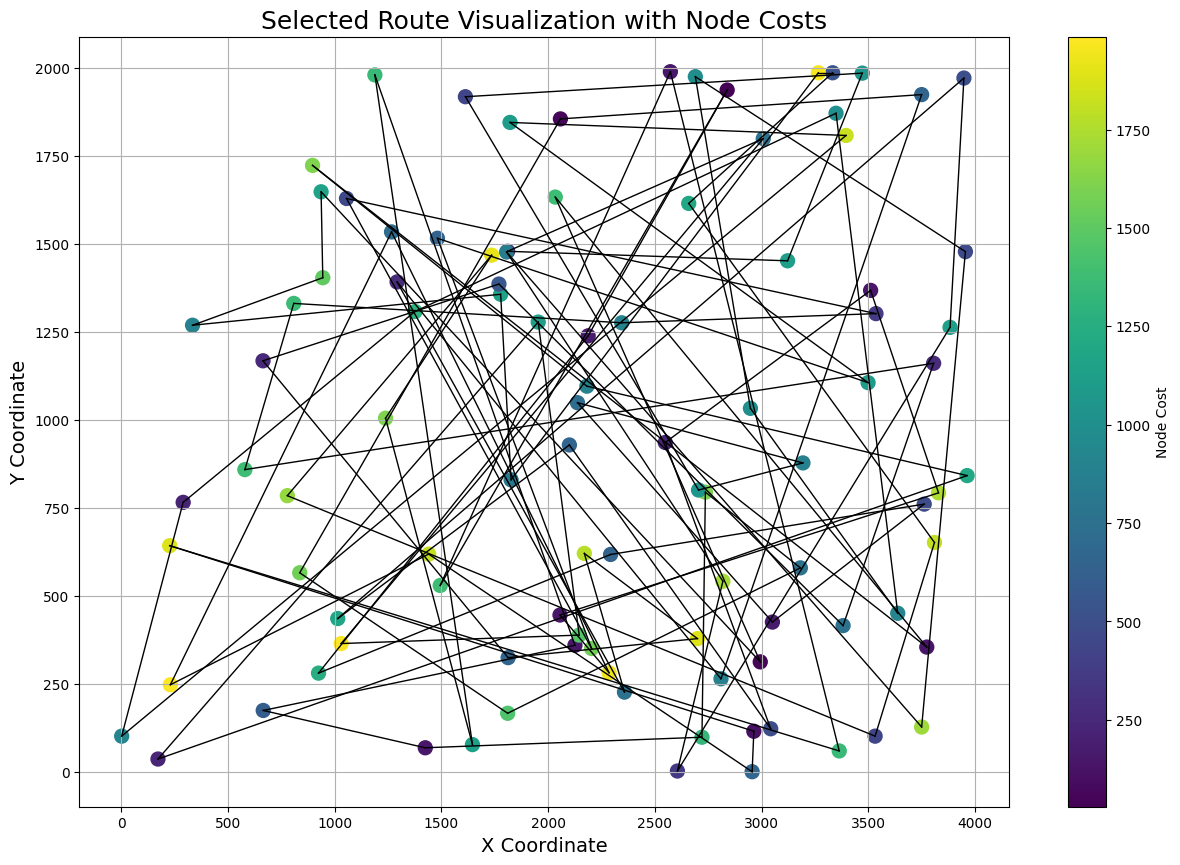

In [19]:
best_A_solution = random_solutions["A"][np.argmin(objectives_values["A"])]

visualize_selected_route(best_A_solution[0], instances["A"])

#### Instance B - best solution ####

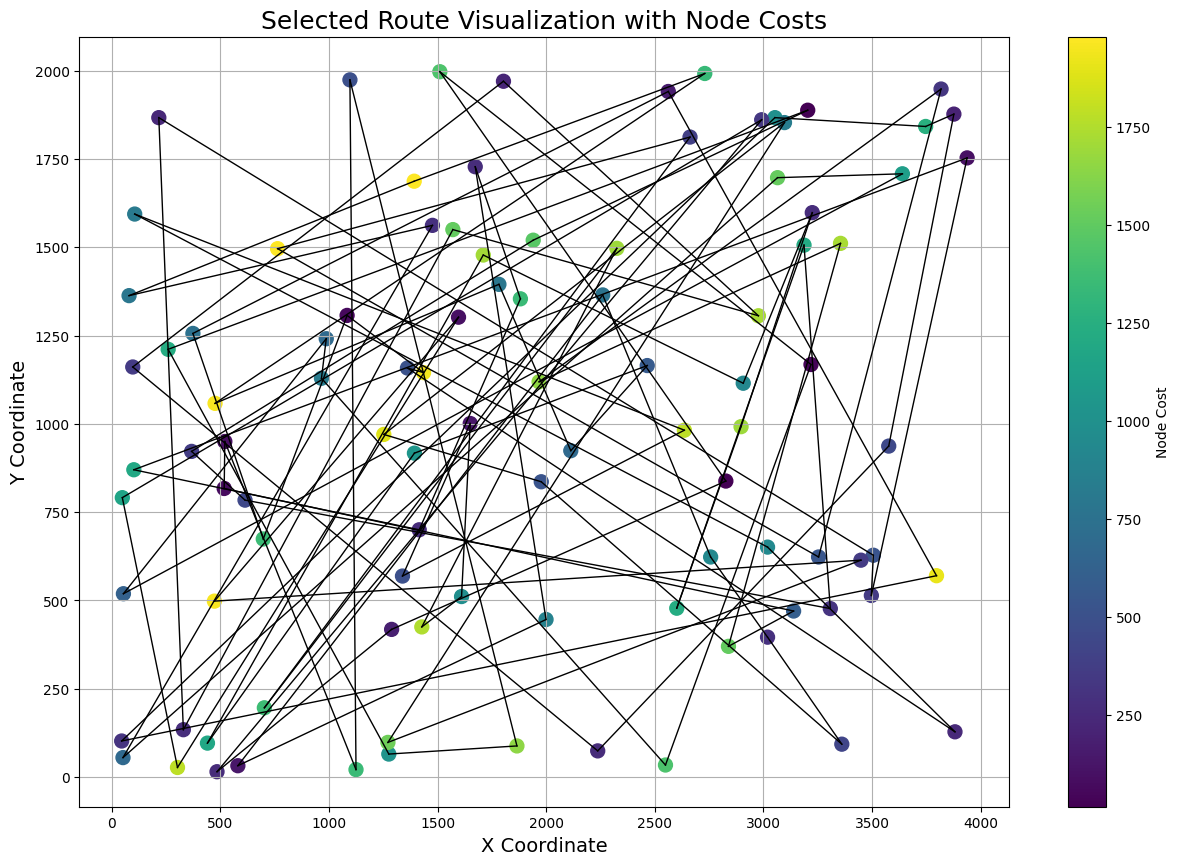

In [20]:
best_B_solution = random_solutions["B"][np.argmin(objectives_values["B"])]
visualize_selected_route(best_B_solution[0], instances["B"])

#### Instance C - best solution

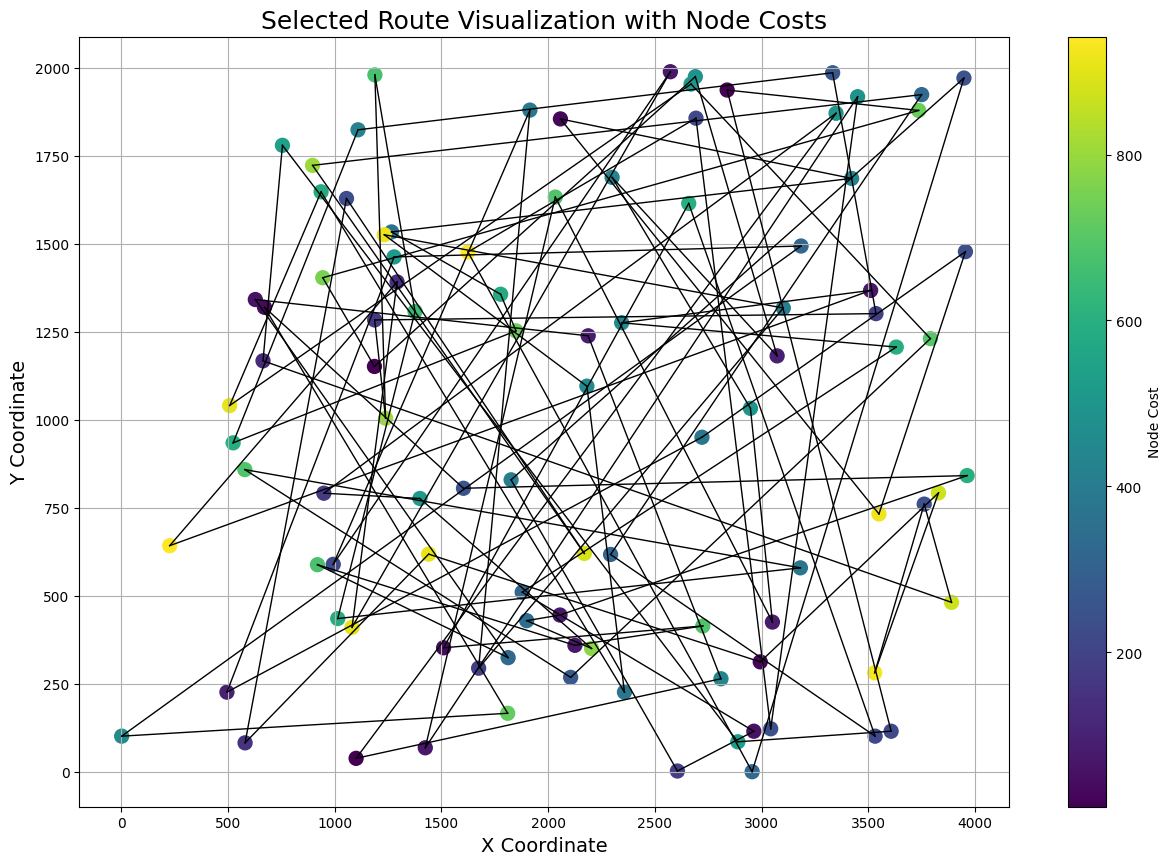

In [21]:
best_C_solution = random_solutions["C"][np.argmin(objectives_values["C"])]
visualize_selected_route(best_C_solution[0], instances["C"])

#### Instance D - best solution ####

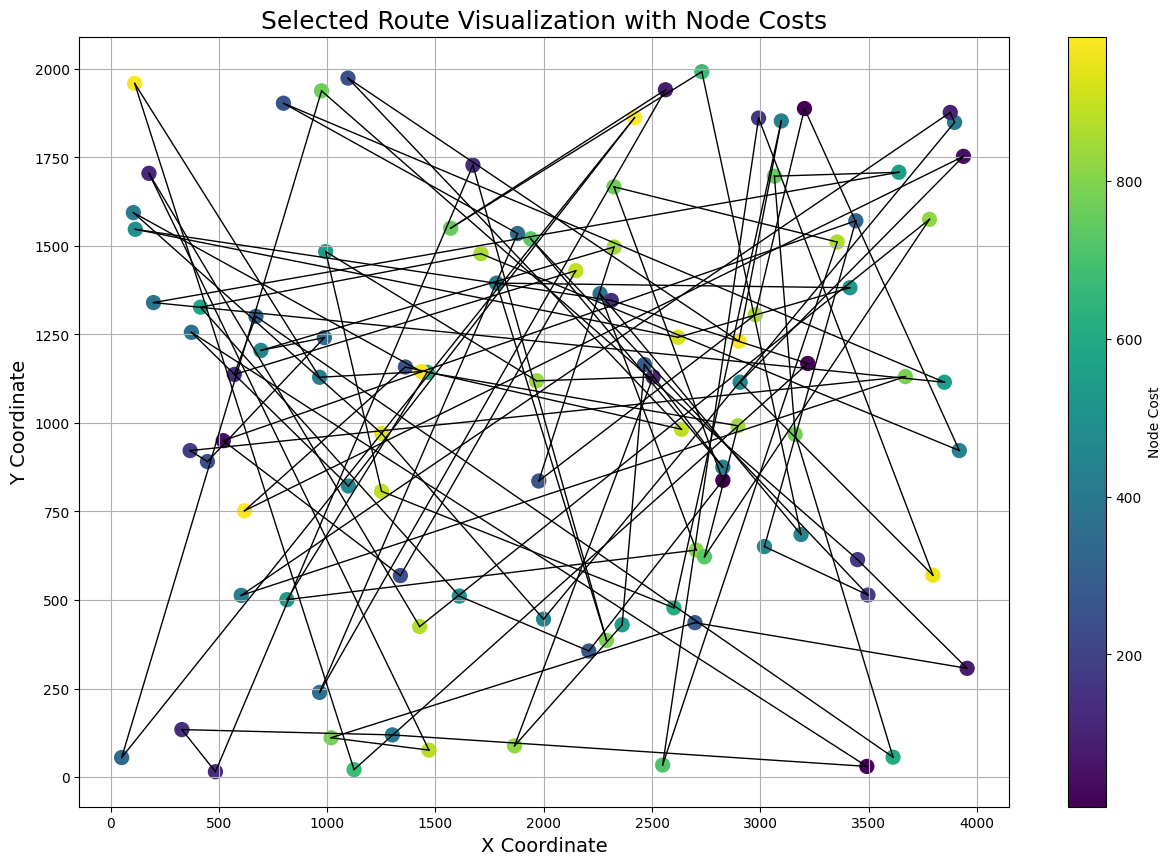

In [22]:
best_D_solution = random_solutions["D"][np.argmin(objectives_values["D"])]
visualize_selected_route(best_D_solution[0], instances["D"])

## Nearest Neighbor ##

### The algorithm ###

In [25]:
def generate_nearest_neighbor_solution(dist_matrix, costs, start_node):
    """
    Generate a solution using the nearest neighbor heuristic.
    Starts from the 'start_node' and repeatedly selects the nearest unselected node.
    """
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2

    selected_nodes = [start_node]    
    unselected_nodes = set(range(num_nodes)) - {start_node}

    while len(selected_nodes) < num_select:
        last_node = selected_nodes[-1]
        nearest_node = min(
            unselected_nodes, 
            key=lambda node: dist_matrix[last_node, node]
        )
        selected_nodes.append(nearest_node)
        unselected_nodes.remove(nearest_node)

    total_distance = sum(
        dist_matrix[selected_nodes[i], selected_nodes[i - 1]] 
        for i in range(num_select)
    )
    total_distance += dist_matrix[selected_nodes[0], selected_nodes[-1]]
    cost = total_cost(selected_nodes, costs)

    return selected_nodes, total_distance + cost

### Running the method ###

In [26]:
num_solutions = 200
nn_solutions = {
    "A": [generate_nearest_neighbor_solution(distances_matrices["A"], costs["A"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "B": [generate_nearest_neighbor_solution(distances_matrices["B"], costs["B"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "C": [generate_nearest_neighbor_solution(distances_matrices["C"], costs["C"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "D": [generate_nearest_neighbor_solution(distances_matrices["D"], costs["D"], start_node=start_node) for start_node in tqdm(range(num_solutions))]
}

nn_objectives_values = {
    "A": [solution[1] for solution in nn_solutions["A"]],
    "B": [solution[1] for solution in nn_solutions["B"]],
    "C": [solution[1] for solution in nn_solutions["C"]],
    "D": [solution[1] for solution in nn_solutions["D"]]
}

nn_selected_nodes = {
    "A": [solution[0] for solution in nn_solutions["A"]],
    "B": [solution[0] for solution in nn_solutions["B"]],
    "C": [solution[0] for solution in nn_solutions["C"]],
    "D": [solution[0] for solution in nn_solutions["D"]]
}

100%|██████████| 200/200 [00:00<00:00, 333.97it/s]


In [27]:
for instance in nn_objectives_values:
    print(f"Instance {instance} - min: {min(nn_objectives_values[instance])}, max: {max(nn_objectives_values[instance])}, mean: {np.mean(nn_objectives_values[instance])}")

Instance A - min: 110324, max: 129148, mean: 117968.495
Instance B - min: 111297, max: 126222, mean: 118569.65
Instance C - min: 62918, max: 75218, mean: 67781.89
Instance D - min: 65217, max: 72859, mean: 69274.92


#### Instance A - best solution ####

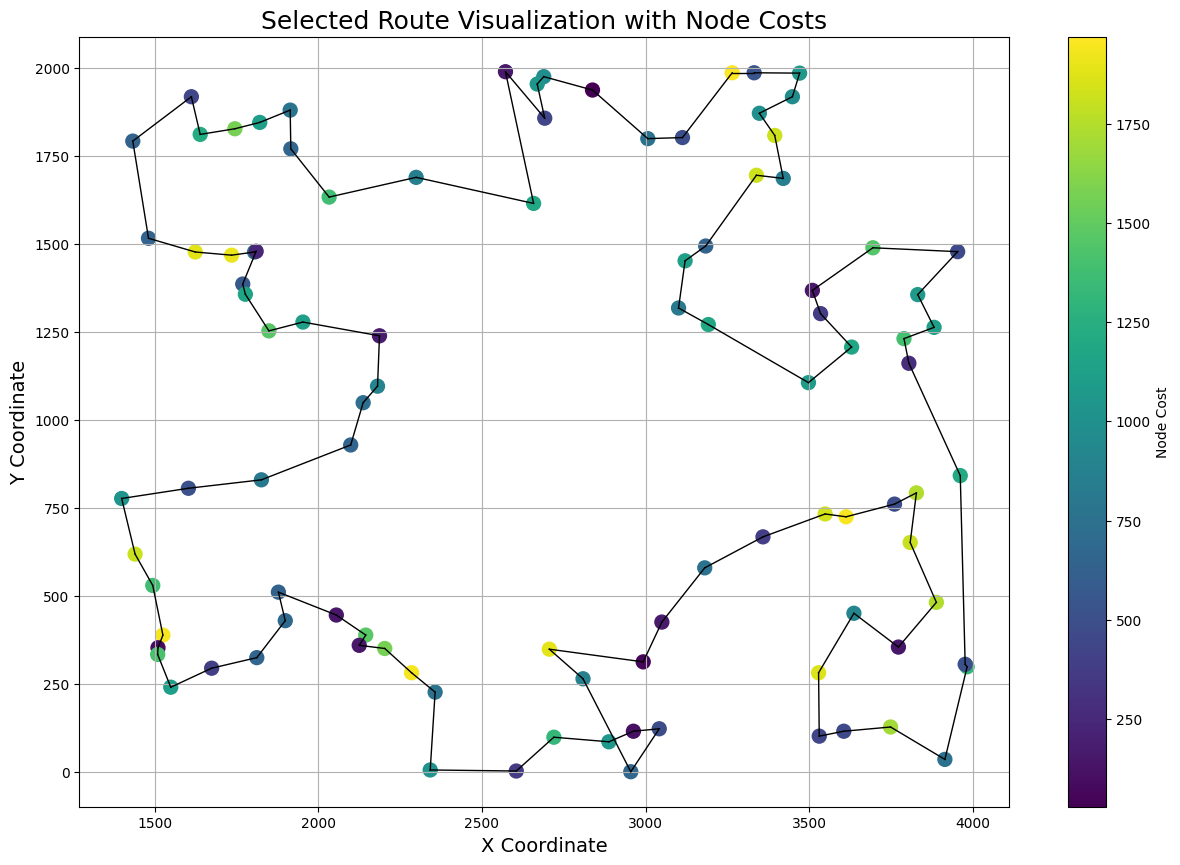

In [28]:
nn_best_A_solution = nn_solutions["A"][np.argmin(nn_objectives_values["A"])]
visualize_selected_route(nn_best_A_solution[0], instances["A"])

#### Instance B - best solution ####

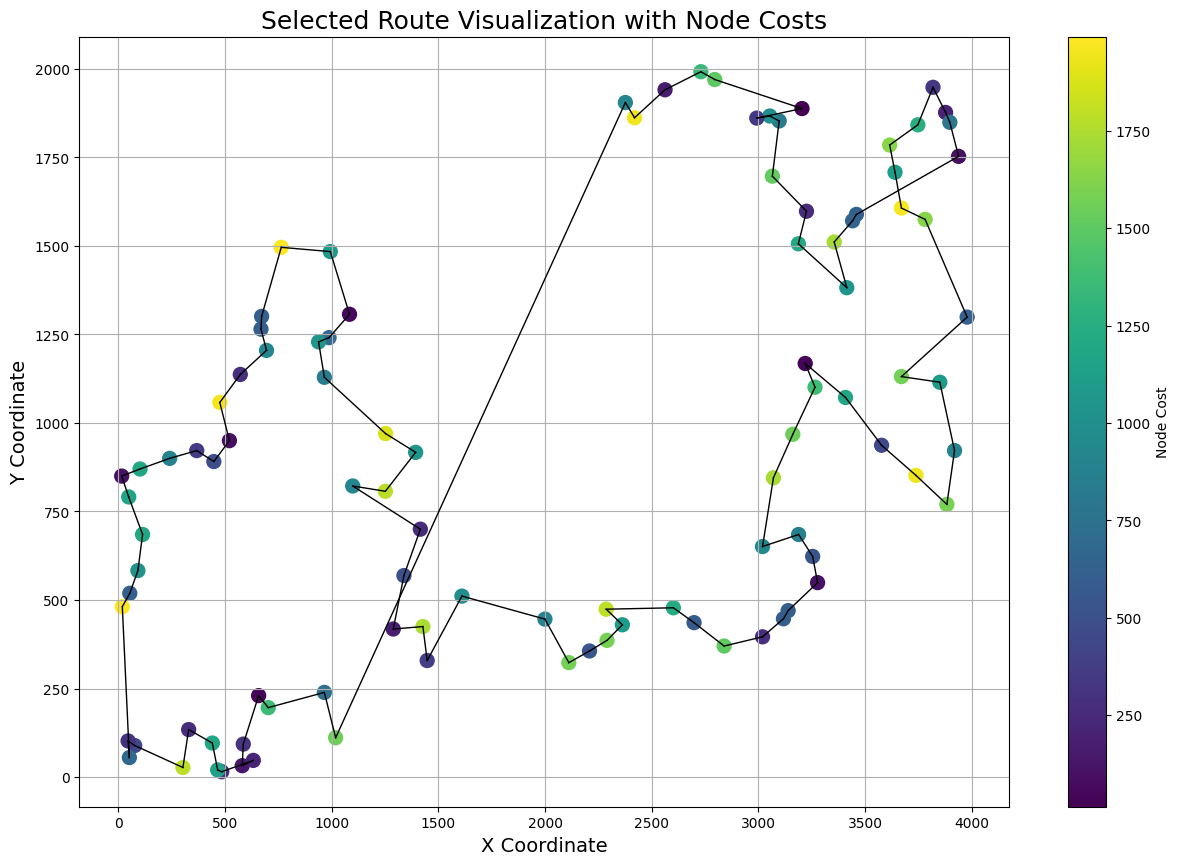

In [29]:
nn_best_B_solution = nn_solutions["B"][np.argmin(nn_objectives_values["B"])]
visualize_selected_route(nn_best_B_solution[0], instances["B"])

#### Instance C - best solution ####

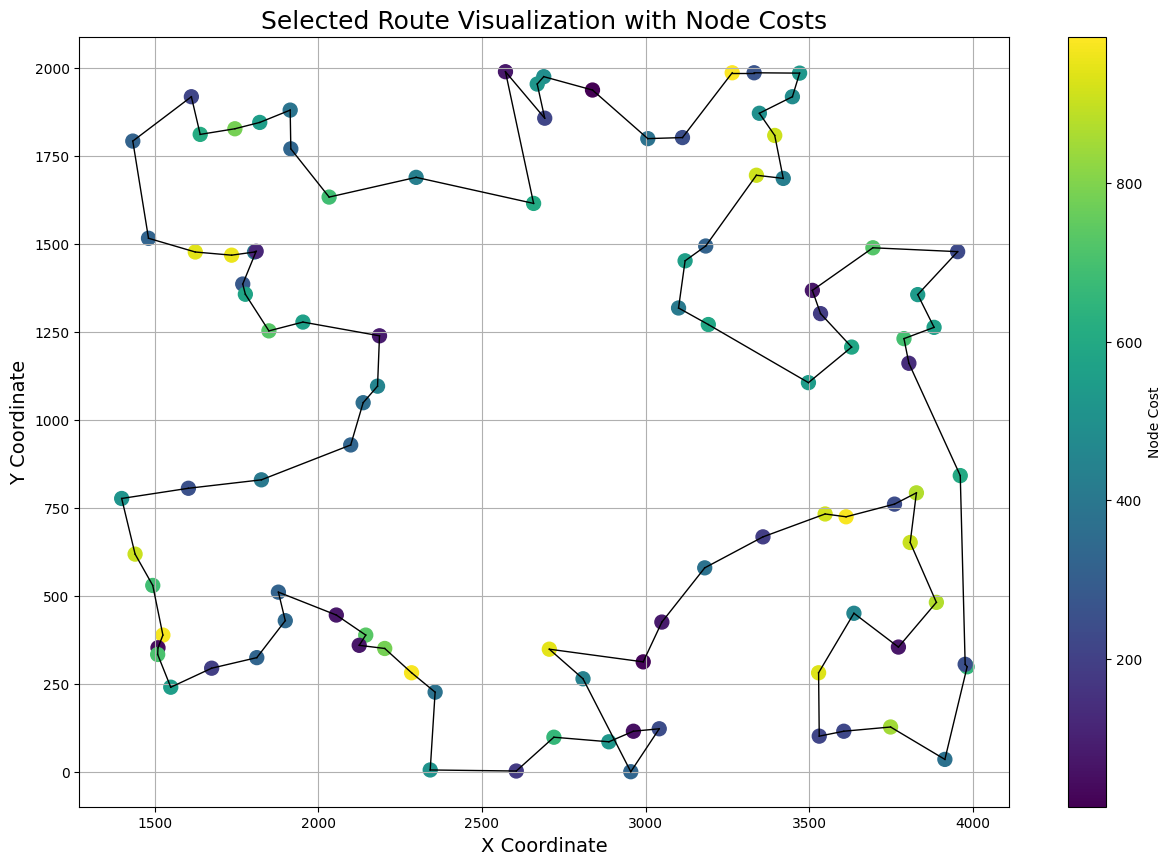

In [30]:
nn_best_C_solution = nn_solutions["C"][np.argmin(nn_objectives_values["C"])]
visualize_selected_route(nn_best_C_solution[0], instances["C"])

#### Instance D - best solution ####

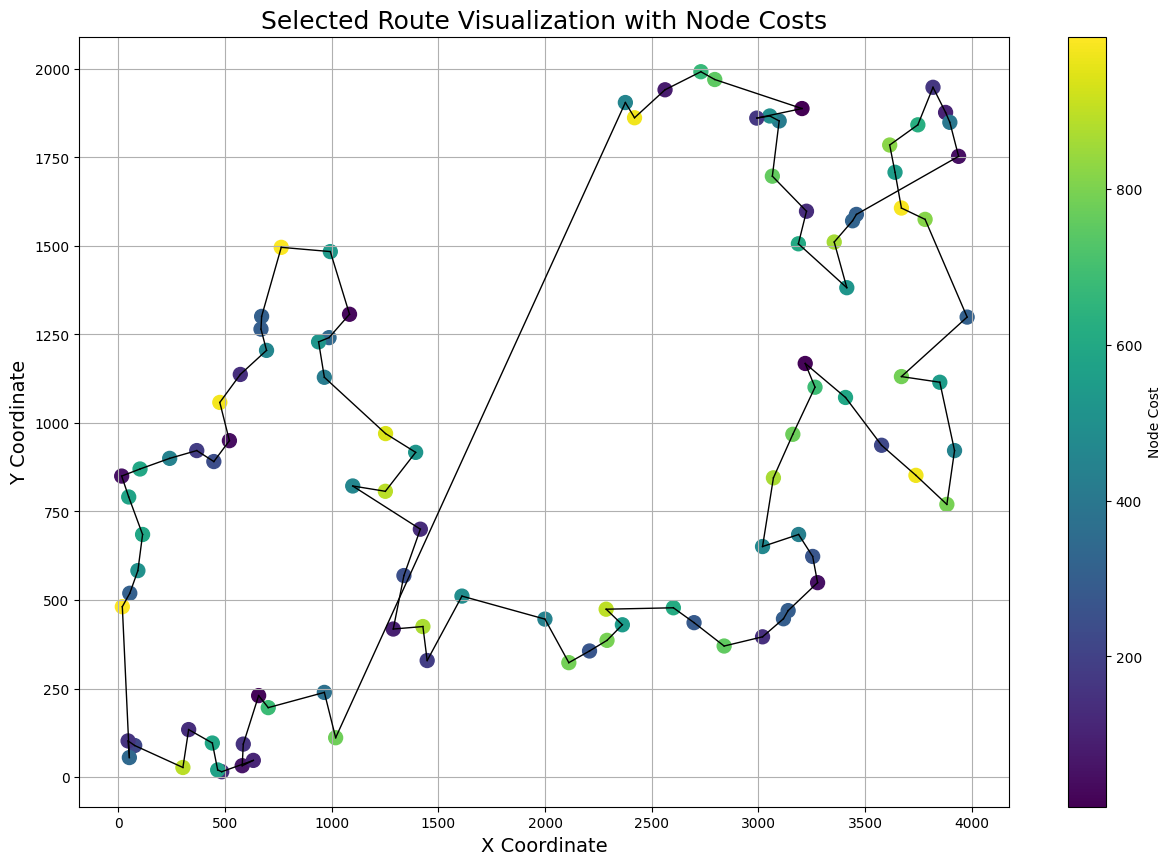

In [31]:
nn_best_D_solution = nn_solutions["D"][np.argmin(nn_objectives_values["D"])]
visualize_selected_route(nn_best_D_solution[0], instances["D"])